In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"   # to prevent kernel dying when using matplotlib with pytorch

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import sampler
from torch.utils.data import random_split
import torchvision.datasets

import torchvision.transforms as T
import torch.nn.functional as F

FOLDER = "C:/Users/PMLS/FYP"
%cd $FOLDER
dtype = torch.float32

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device used:", device)

C:\Users\PMLS\FYP
Device used: cpu


In [92]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, input_size, size1, size2, num_classes):
        # define layers of nn
        super().__init__()
        self.layer1 = nn.Linear(input_size, size1)
        self.layer2 = nn.Linear(size1, size2)
        self.layer3 = nn.Linear(size2, num_classes)

        # Subtract the mean and divide by standard deviation
        nn.init.kaiming_normal_(self.layer1.weight)
        nn.init.kaiming_normal_(self.layer2.weight)
        nn.init.kaiming_normal_(self.layer3.weight)

    def forward(self, x):
        # Implement the forward function (connect the layers)
        out1 = F.relu(self.layer1(x))
        out2 = F.relu(self.layer2(out1))
        scores = self.layer3(out2)

        return scores   # for each image, model gives a score to each class

In [109]:
# Prepare dataset
def flatten(x):
    # Convert multidimensional matrix to 2D matrix (Nxd)
    # i.e convert input into a 1d vector per sample
    return x.view(len(x), -1)

# Preprocessing on images
size = 32
transforms = T.Compose([T.ToTensor(),
                       T.Resize([size,size])
                       ])
# Load images from folder
dataset = torchvision.datasets.ImageFolder(f"{FOLDER}/datasets/leapGestRecog/all",
                                           transform = transforms)

leapGestRecog_classmap = {0:"palm",1:"L",2:"fist",3:"fist_moved",4:"thumb",5:"index",6:"ok",7:"palm_moved",8:"c",9:"down"}

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7,0.2,0.1])
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size,  shuffle=True)
test_loader = DataLoader(test_dataset,   batch_size=batch_size,  shuffle=True)

In [110]:
%%time

def train_model(model, data, epochs):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    all_loss = []
    for e in range(epochs):
        for t, (x, y) in enumerate(data):
            x = x.to(device)
            model.train()  # put model to training mode
            x = flatten(x)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device)

            scores = model(x)
            loss = Loss_function(scores, y)

            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        if e % (max(epochs//10, 1)) == 0:
            print('Iteration %d, loss = %.4f' % (e, loss.item()))
            all_loss.append(loss.item())
    #plt.plot(all_loss)
    print("Training complete")

model = ThreeLayerConvNet(3*size*size,12,8,10)
Loss_function =  F.cross_entropy

# learning_rate = 1e-1
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# train_model(model, train_loader, 2)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_model(model, train_loader, 10)

Iteration 0, loss = 2.1781
Iteration 1, loss = 0.0581
Iteration 2, loss = 0.1624
Iteration 3, loss = 0.3823
Iteration 4, loss = 0.0719
Iteration 5, loss = 0.0155
Iteration 6, loss = 0.0062
Iteration 7, loss = 0.0075
Iteration 8, loss = 1.0375
Iteration 9, loss = 0.0054
Training complete 😊
CPU times: total: 4min 52s
Wall time: 13min 20s


In [113]:
# Validation testing model
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            x = flatten(x)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()            
        num_samples = batch_size*len(loader)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
check_accuracy_part34(valid_loader, model)

Got 3972 / 4000 correct (99.30)


prediction = fist_moved, label = fist_moved


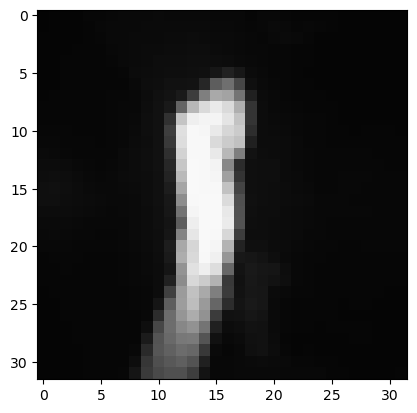

In [114]:
# Manual testing of model
# Pick random image from test dataset
model.eval()
with torch.no_grad():
    for t, (x, y) in enumerate(test_loader):
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        xf = flatten(x)
        scores = model(xf)
        _, preds = scores.max(1)
        print(f"prediction = {leapGestRecog_classmap[int(preds[0])]}, label = {leapGestRecog_classmap[int(y[0])]}")
        image = x[0].permute(1, 2, 0).numpy()
        plt.imshow(image)
        break